In [1]:
import os
import sys
import re
from pathlib import Path
import pdfplumber
import pytesseract
from pdf2image import convert_from_path
import warnings
import logging
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
import shap

sys.path.append('../python')
warnings.filterwarnings('default')
logging.getLogger("pdfminer").setLevel(logging.ERROR)

import api
import data_tools as dt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB

rng = np.random.default_rng(12898)

MAX_DOC_FREQ = 0.95    # ignore tokens that appear in 95% of documents
MIN_DOC_FREQ = 5       # ignore tokens that appear in less than 5 documents
MIN_DATES = 3          # ignore terms that appear in less than 2 dates


/Users/ekung/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ekung/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ekung/Library/Python/3.9/lib/python/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/ekung/Library/Python/3.9/lib/python/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


In [2]:
df = dt.get_supplemental_docs(verbose=False, clean=False)

In [3]:
idx = df['support_or_oppose'].isin(['Definitely Oppose', 'Definitely Support', 'Somewhat Oppose', 'Somewhat Support'])
idx_support = df['support_or_oppose'].isin(['Definitely Support', 'Somewhat Support'])
idx_oppose = df['support_or_oppose'].isin(['Definitely Oppose', 'Somewhat Oppose'])

print(f"Number of documents: {idx.sum():,g}")
print(f"Number of support documents: {idx_support.sum():,g}")
print(f"Number of oppose documents: {idx_oppose.sum():,g}")

Number of documents: 4,452
Number of support documents: 2,150
Number of oppose documents: 2,302


In [4]:
df2 = df.loc[idx].reset_index(drop=True)

In [5]:
# Build vocabulary. 

# Only include tokens that appear in the supplemental docs of at least 3 meetings
documents_by_date = []
for date in list(df2['date'].unique()):
    year = date[0:4]
    all_content = '\n\n'.join(list(df2.loc[df2['date']==date, 'content']))
    documents_by_date.append(all_content)

cv = CountVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    strip_accents='unicode',
    min_df=MIN_DATES
)

X = cv.fit_transform(documents_by_date)
vocab = cv.get_feature_names_out()
vocab = [tok for tok in vocab if not tok.isdigit()]  # no pure numerical tokens

In [6]:
# Further refine the vocabulary
documents = list(df2['content'])
cv = CountVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    strip_accents='unicode',
    vocabulary=vocab,
    max_df=MAX_DOC_FREQ,    # ignore tokens that appear in 95% of documents
    min_df=MIN_DOC_FREQ,    # include only tokens that appear at least twice
)
X = cv.fit_transform(documents)
vocab = cv.get_feature_names_out()

In [7]:
# Construct a token df
documents = list(df2['content'])
y = df2['support_or_oppose'].isin(['Definitely Support', 'Somewhat Support'])
support_docs = list(df2.loc[y, 'content'])
oppose_docs = list(df2.loc[~y, 'content'])

count_vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    strip_accents='unicode',
    vocabulary=vocab
)
tf_vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    strip_accents='unicode',
    vocabulary=vocab,
    use_idf=False,
    norm=None
)
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    strip_accents='unicode',
    vocabulary=vocab,
    use_idf=True,
    norm=None
)

# On all documents
X = count_vectorizer.fit_transform(documents)
tokens = count_vectorizer.get_feature_names_out()
occurrences = X.sum(axis=0)
doc_freq = (X>0).sum(axis=0)
TF = tf_vectorizer.fit_transform(documents)
TFIDF = tfidf_vectorizer.fit_transform(documents)
IDF = tfidf_vectorizer.idf_

# On supports
X = count_vectorizer.fit_transform(support_docs)
occurrences_support = X.sum(axis=0)
doc_freq_support = (X>0).sum(axis=0)
TF_support = tf_vectorizer.fit_transform(support_docs)
TFIDF_support = tfidf_vectorizer.fit_transform(support_docs)
IDF_support = tfidf_vectorizer.idf_

# On opps
X = count_vectorizer.fit_transform(oppose_docs)
occurrences_oppose = X.sum(axis=0)
doc_freq_oppose = (X>0).sum(axis=0)
TF_oppose = tf_vectorizer.fit_transform(oppose_docs)
TFIDF_oppose = tfidf_vectorizer.fit_transform(oppose_docs)
IDF_oppose = tfidf_vectorizer.idf_


words_df = pd.DataFrame({
    'token': tokens, 'occurrences': occurrences.A1, 'doc_freq': doc_freq.A1,
    'tfidf': TFIDF.sum(axis=0).A1,
    'tfidf_support': (TF_support.multiply(IDF)).sum(axis=0).A1,
    'tfidf_oppose': (TF_oppose.multiply(IDF)).sum(axis=0).A1
})


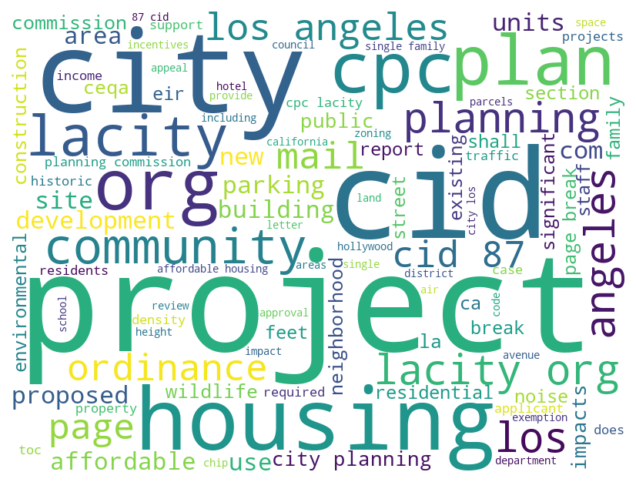

In [8]:
# Overall word cloud

wc_data = dict(zip(words_df['token'], words_df['tfidf']))

wordcloud = WordCloud(
    width=800,
    height=600,
    max_words=100,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(wc_data)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [9]:
# xgboost binary classifier

tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    strip_accents='unicode',
    vocabulary=vocab,
    use_idf=True,
)

documents = list(df2['content'])
y = df2['support_or_oppose'].isin(['Definitely Support', 'Somewhat Support'])

X = tfidf_vectorizer.fit_transform(documents)
feature_names = tfidf_vectorizer.get_feature_names_out()

model = XGBClassifier(eval_metric='logloss')
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [11]:
explainer = shap.Explainer(model)
shap_values = explainer(X)
importance_df = pd.DataFrame({
    'token': feature_names,
    'importance': shap_values.values.mean(axis=0)
})

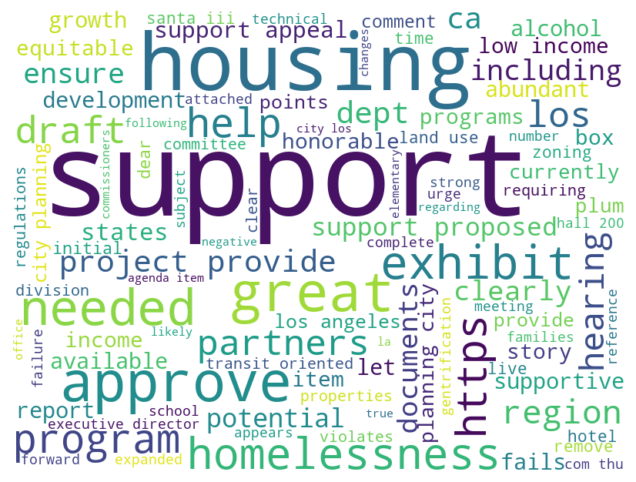

In [15]:
# Support Word Cloud

wc_data = dict(zip(importance_df['token'], importance_df['importance']))

wordcloud = WordCloud(
    width=800,
    height=600,
    max_words=100,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(wc_data)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


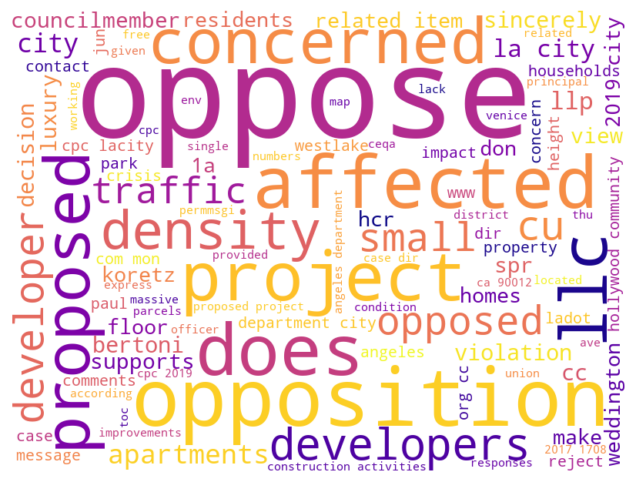

In [16]:
# Oppose Word Cloud

wc_data = dict(zip(importance_df['token'], -importance_df['importance']))

wordcloud = WordCloud(
    width=800,
    height=600,
    max_words=100,
    background_color='white',
    colormap='plasma'
).generate_from_frequencies(wc_data)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
